In [3]:
from pathlib import Path

In [4]:
path = Path('/fastdata/contrails')
files = list(path.glob('*'))
files

[PosixPath('/fastdata/contrails/train'),
 PosixPath('/fastdata/contrails/sample_submission.csv'),
 PosixPath('/fastdata/contrails/stats.csv'),
 PosixPath('/fastdata/contrails/validation_metadata.json'),
 PosixPath('/fastdata/contrails/train_metadata.json'),
 PosixPath('/fastdata/contrails/validation'),
 PosixPath('/fastdata/contrails/test')]

In [73]:
import pandas as pd

train_metdata = pd.read_json(path/'train_metadata.json')
len(train_metdata)

20529

In [74]:
import os 

records = os.listdir(path / 'train')
len(records)

20529

In [75]:
val_metadata = pd.read_json(path/'validation_metadata.json')
len(val_metadata)

1856

In [76]:
val_records = os.listdir(path / 'validation')
len(val_records)

1856

In [77]:
record_id = records[0]

files = list(path.glob(f'train/{record_id}/*'))
# files = os.listdir(path / 'train' / record_id)
files

[PosixPath('/fastdata/contrails/train/2175739284570639142/band_15.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_09.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_12.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_10.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/human_pixel_masks.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_14.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_16.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_13.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_08.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/all_bands.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/all_bands_t5.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/band_11.npy'),
 PosixPath('/fastdata/contrails/train/2175739284570639142/human_individual_masks.npy')]

In [85]:
import numpy as np 

image = np.load('/fastdata/contrails/train/2175739284570639142/band_15.npy')
image.shape

(256, 256, 8)

In [86]:
image.min(), image.max(), image.dtype

(244.4923, 286.61728, dtype('float32'))

In [79]:
mask = np.load('/fastdata/contrails/train/2175739284570639142/human_pixel_masks.npy')
mask.shape

(256, 256, 1)

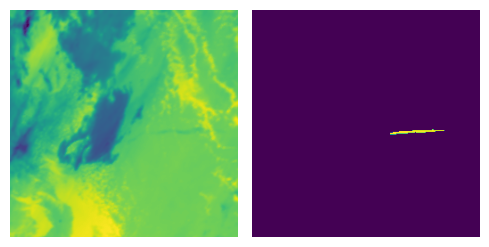

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(1, 2, 1)
ax.imshow(image[...,4])
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.imshow(mask[...,0])
ax.axis('off')
plt.tight_layout()
plt.show()

In [84]:
image = np.load('/fastdata/contrails/train/2175739284570639142/all_bands_t5.npy')
image.shape, image.dtype, image.min(), image.max()

((256, 256, 9), dtype('float32'), -2.4396756, 1.5977907)

In [87]:
image = np.load('/fastdata/contrails/train/2175739284570639142/all_bands.npy')
image.shape, image.dtype, image.min(), image.max()

((256, 256, 8, 9), dtype('float32'), -2.4449592, 1.7724015)

In [20]:
def get_stats(args):
    record, band = args
    image = np.load(path / 'train' / record / f'band_{band:02d}.npy')
    return band, image.min(), image.max(), image.mean(), image.std()

In [21]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm import tqdm

In [22]:
num_cores = multiprocessing.cpu_count()
bands = range(8,17)
stats = {b: {'min': [], 'max': [], 'mean': [], 'std': []} for b in bands}
args = [(record, band) for record in records for band in bands]
with ProcessPoolExecutor(max_workers=num_cores) as pool:
    with tqdm(total=len(args)) as progress:
        futures = []
        for arg in args:
            future = pool.submit(get_stats, arg) # enviamos la tupla de argumentos
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)
        results = []
        for future in futures:
            result = future.result()
            results.append(result)

100%|██████████| 184761/184761 [02:02<00:00, 1510.34it/s]


In [23]:
stats = {b: {'min': [], 'max': [], 'mean': [], 'std': []} for b in bands}
for band, min_, max_, mean_, std_ in results:
    stats[band]['min'].append(min_)
    stats[band]['max'].append(max_)
    stats[band]['mean'].append(mean_)
    stats[band]['std'].append(std_)

In [24]:
final_stats = {
    b: {
        'min': np.min(stats[b]['min']), 
        'max': np.max(stats[b]['max']),
        'mean': np.mean(stats[b]['mean']),
        'std': np.mean(stats[b]['std'])
        } 
    for b in bands
}

final_stats

{8: {'min': 175.82391, 'max': 280.14868, 'mean': 233.67686, 'std': 4.545741},
 9: {'min': 180.74695, 'max': 279.4869, 'mean': 242.25447, 'std': 6.0571766},
 10: {'min': 181.44263, 'max': 331.13394, 'mean': 250.75069, 'std': 7.620164},
 11: {'min': 179.33739, 'max': 332.06036, 'mean': 274.41205, 'std': 13.668153},
 12: {'min': 187.69131, 'max': 306.21823, 'mean': 255.52716, 'std': 8.708825},
 13: {'min': 179.3451, 'max': 338.0567, 'mean': 276.60184, 'std': 14.446373},
 14: {'min': 178.71164, 'max': 338.6333, 'mean': 275.3594, 'std': 14.736154},
 15: {'min': 178.36511, 'max': 333.21048, 'mean': 272.5641, 'std': 14.367307},
 16: {'min': 137.39153, 'max': 311.97977, 'mean': 260.4258, 'std': 11.04905}}

In [29]:
df = pd.DataFrame(final_stats)
df = df.T
df 

,min,max,mean,std
8,175.823914,280.148682,233.676865,4.545741
9,180.746948,279.486908,242.254471,6.057177
10,181.442627,331.133942,250.750687,7.620164
11,179.337387,332.060364,274.412048,13.668153
12,187.691315,306.218231,255.527161,8.708825
13,179.345093,338.056702,276.601837,14.446373
14,178.711639,338.633301,275.359406,14.736154
15,178.365112,333.210480,272.564087,14.367307
16,137.391525,311.979767,260.425812,11.049050


In [32]:
df.to_csv(path/'stats.csv')

In [35]:
stats = pd.read_csv(path/'stats.csv', index_col=0)
stats

,min,max,mean,std
8,175.82391,280.14868,233.67686,4.545741
9,180.74695,279.48690,242.25447,6.057177
10,181.44263,331.13394,250.75069,7.620164
11,179.33739,332.06036,274.41205,13.668153
12,187.69131,306.21823,255.52716,8.708825
13,179.34510,338.05670,276.60184,14.446373
14,178.71164,338.63330,275.35940,14.736154
15,178.36511,333.21048,272.56410,14.367307
16,137.39153,311.97977,260.42580,11.049050


In [88]:
def preprocess(arg):
    record, mode = arg
    bands = range(8,17)
    data = []
    for band in bands:
        image = np.load(path / mode / record / f'band_{band:02d}.npy')
        image = (image - stats.loc[band]['mean']) / stats.loc[band]['std']
        data.append(image)
    data = np.stack(data, axis=-1)
    np.save(path / mode / record / f'all_bands.npy', data)
    np.save(path / mode / record / f'all_bands_t5.npy', data[...,4,:])
    return 

In [90]:
# args = [(record, 'train') for record in records]
args = [(record, 'validation') for record in val_records]

with ProcessPoolExecutor(max_workers=num_cores) as pool:
    with tqdm(total=len(args)) as progress:
        futures = []
        for arg in args:
            future = pool.submit(preprocess, arg) # enviamos la tupla de argumentos
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)
        results = []
        for future in futures:
            result = future.result()
            results.append(result)

  0%|          | 0/1856 [00:00<?, ?it/s]

100%|██████████| 1856/1856 [00:34<00:00, 53.60it/s]


In [5]:
import pandas as pd 

sample_submission = pd.read_csv(path/'sample_submission.csv')
sample_submission

,record_id,encoded_pixels
0,1000834164244036115,1 3 10 5
1,1002653297254493116,-
